### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_backends 
from my_backends.ducc0_wrapper import *
import my_shcoeffs
from my_shcoeffs import SHCoeffs
## my_shcoeffs contains expand_adjoint_analysis

[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmbar.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmbar_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plbar.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plbar_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmon.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmon_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plon.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plon_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmschmidt.doc'
[Errno 2] No such file or dir

In [2]:
import torch

N = 20
from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 1000
problem = Problem_Sphere_Poisson()

In [3]:
N = 20
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([800, 2])

iteration 0: loss = 34.68910598754883, pde loss = 34.68910598754883


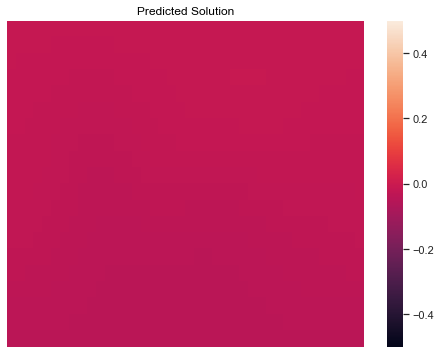

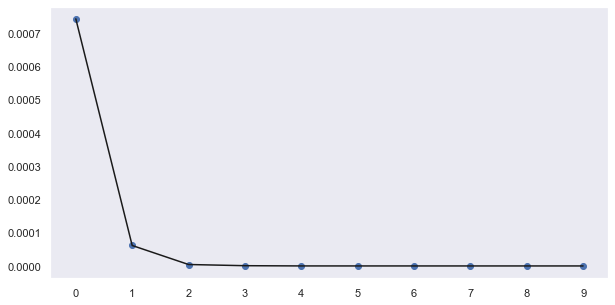

iteration 10: loss = 34.27821350097656, pde loss = 34.27821350097656
iteration 20: loss = 33.42402267456055, pde loss = 33.42402267456055
iteration 30: loss = 33.07029724121094, pde loss = 33.07029724121094
iteration 40: loss = 32.920631408691406, pde loss = 32.920631408691406
iteration 50: loss = 32.84034729003906, pde loss = 32.84034729003906
iteration 60: loss = 32.670745849609375, pde loss = 32.670745849609375
iteration 70: loss = 31.580339431762695, pde loss = 31.580339431762695
iteration 80: loss = 27.763208389282227, pde loss = 27.763208389282227
iteration 90: loss = 26.03277587890625, pde loss = 26.03277587890625
iteration 100: loss = 24.0577392578125, pde loss = 24.0577392578125
iteration 110: loss = 21.402267456054688, pde loss = 21.402267456054688
iteration 120: loss = 18.627416610717773, pde loss = 18.627416610717773
iteration 130: loss = 15.566990852355957, pde loss = 15.566990852355957
iteration 140: loss = 12.241260528564453, pde loss = 12.241260528564453
iteration 150: 

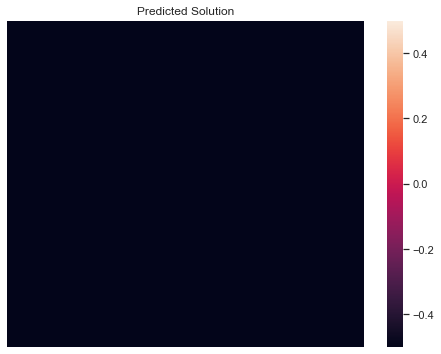

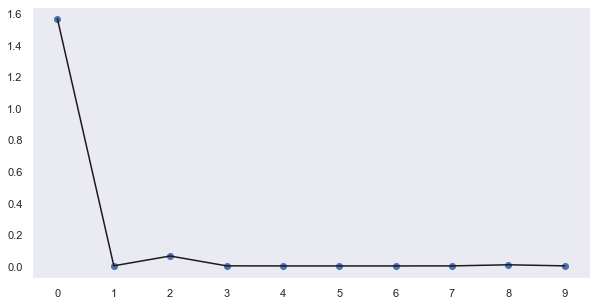

iteration 210: loss = 0.30893445014953613, pde loss = 0.30893445014953613
iteration 220: loss = 0.21885286271572113, pde loss = 0.21885286271572113
iteration 230: loss = 0.15882305800914764, pde loss = 0.15882305800914764
iteration 240: loss = 0.1248432844877243, pde loss = 0.1248432844877243
iteration 250: loss = 0.1119554415345192, pde loss = 0.1119554415345192
iteration 260: loss = 0.09041925519704819, pde loss = 0.09041925519704819
iteration 270: loss = 0.09441861510276794, pde loss = 0.09441861510276794
iteration 280: loss = 0.07297303527593613, pde loss = 0.07297303527593613
iteration 290: loss = 0.07465776801109314, pde loss = 0.07465776801109314
iteration 300: loss = 0.06821706891059875, pde loss = 0.06821706891059875
iteration 310: loss = 0.06713496893644333, pde loss = 0.06713496893644333
iteration 320: loss = 0.053976427763700485, pde loss = 0.053976427763700485
iteration 330: loss = 0.061173245310783386, pde loss = 0.061173245310783386
iteration 340: loss = 0.05220392718911

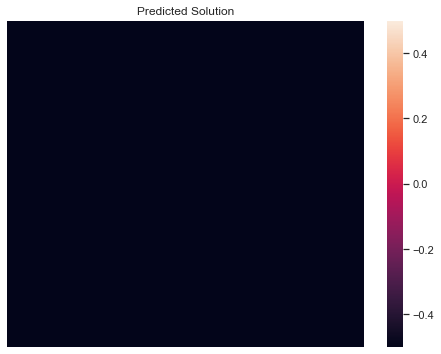

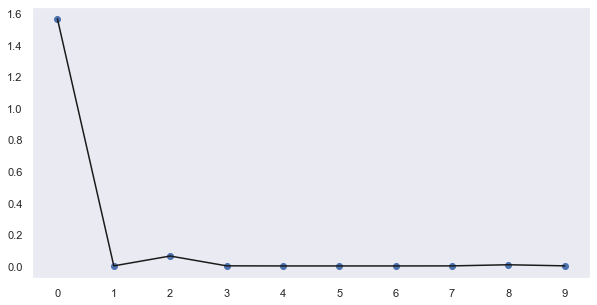

iteration 410: loss = 0.04376683756709099, pde loss = 0.04376683756709099
iteration 420: loss = 0.04708356037735939, pde loss = 0.04708356037735939
iteration 430: loss = 0.04753844439983368, pde loss = 0.04753844439983368
iteration 440: loss = 0.046532440930604935, pde loss = 0.046532440930604935
iteration 450: loss = 0.04225490242242813, pde loss = 0.04225490242242813
iteration 460: loss = 0.05063942074775696, pde loss = 0.05063942074775696
iteration 470: loss = 0.04848216846585274, pde loss = 0.04848216846585274
iteration 480: loss = 0.049315739423036575, pde loss = 0.049315739423036575
iteration 490: loss = 0.03569013252854347, pde loss = 0.03569013252854347
iteration 500: loss = 0.03616352006793022, pde loss = 0.03616352006793022
iteration 510: loss = 0.03908085823059082, pde loss = 0.03908085823059082
iteration 520: loss = 0.042262058705091476, pde loss = 0.042262058705091476
iteration 530: loss = 0.03264124318957329, pde loss = 0.03264124318957329
iteration 540: loss = 0.05008577

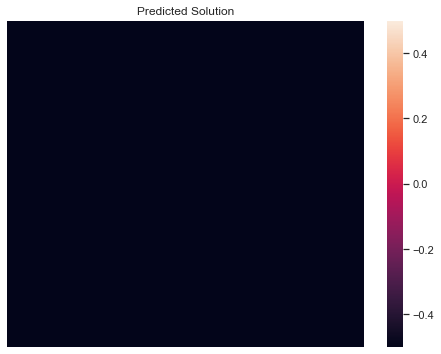

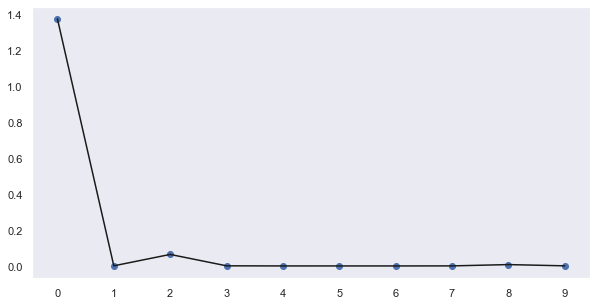

iteration 610: loss = 0.04126871004700661, pde loss = 0.04126871004700661
iteration 620: loss = 0.02799820341169834, pde loss = 0.02799820341169834
iteration 630: loss = 0.037021998316049576, pde loss = 0.037021998316049576
iteration 640: loss = 0.02776174619793892, pde loss = 0.02776174619793892
iteration 650: loss = 0.03616710752248764, pde loss = 0.03616710752248764
iteration 660: loss = 0.028713714331388474, pde loss = 0.028713714331388474
iteration 670: loss = 0.02836134470999241, pde loss = 0.02836134470999241
iteration 680: loss = 0.023112338036298752, pde loss = 0.023112338036298752
iteration 690: loss = 0.031218983232975006, pde loss = 0.031218983232975006
iteration 700: loss = 0.02608800120651722, pde loss = 0.02608800120651722
iteration 710: loss = 0.027941014617681503, pde loss = 0.027941014617681503
iteration 720: loss = 0.023094989359378815, pde loss = 0.023094989359378815
iteration 730: loss = 0.029345888644456863, pde loss = 0.029345888644456863
iteration 740: loss = 0.

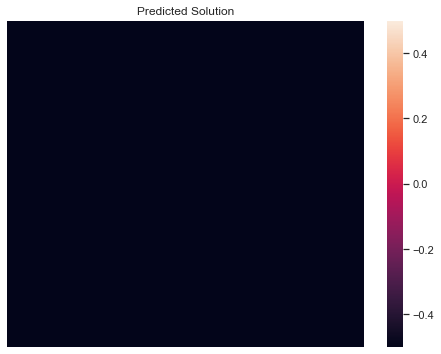

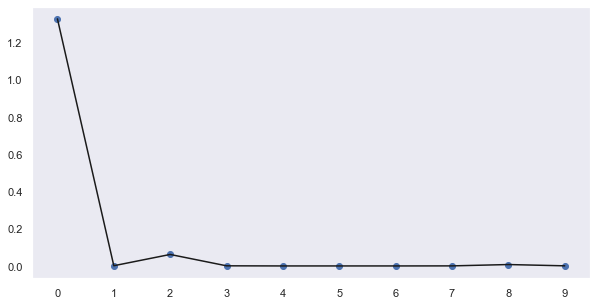

iteration 810: loss = 0.02699161134660244, pde loss = 0.02699161134660244
iteration 820: loss = 0.0220093484967947, pde loss = 0.0220093484967947
iteration 830: loss = 0.04197292402386665, pde loss = 0.04197292402386665
iteration 840: loss = 0.02420799806714058, pde loss = 0.02420799806714058
iteration 850: loss = 0.023628078401088715, pde loss = 0.023628078401088715
iteration 860: loss = 0.029752260074019432, pde loss = 0.029752260074019432
iteration 870: loss = 0.03652515262365341, pde loss = 0.03652515262365341
iteration 880: loss = 0.02638939768075943, pde loss = 0.02638939768075943
iteration 890: loss = 0.02397097833454609, pde loss = 0.02397097833454609
iteration 900: loss = 0.03163270652294159, pde loss = 0.03163270652294159
iteration 910: loss = 0.03445262089371681, pde loss = 0.03445262089371681
iteration 920: loss = 0.022748660296201706, pde loss = 0.022748660296201706
iteration 930: loss = 0.022707166150212288, pde loss = 0.022707166150212288
iteration 940: loss = 0.02398188

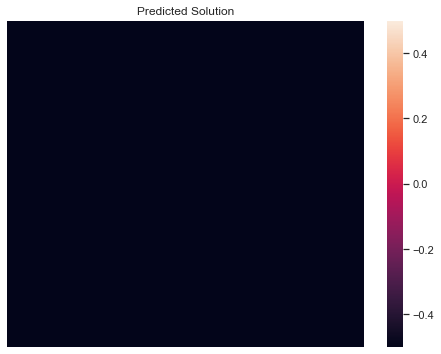

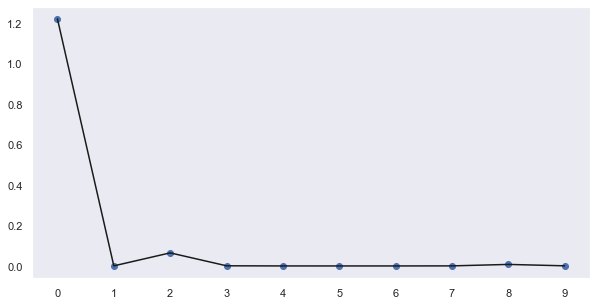

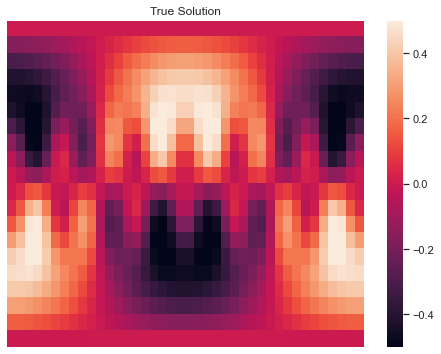

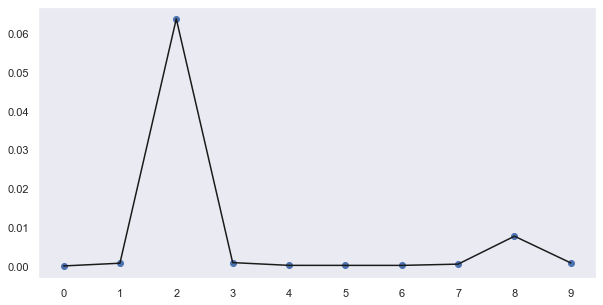

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
#             self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])
            self.loss_history.append([self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            return location # numpy ndarray with shape (N, 2*N)

        def bc_sample(self):
            return torch.tensor([[1., 1.]]) # arbitrary point is okay?

        def init_sample(self):
            pass

        def plot(self, net):
#             azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
#             polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
#             azimuth, polar = torch.meshgrid(azimuth, polar)
#             location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            location = self.inner_sample()
            value = net(location) # predicted solution
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
            self.sht_value(value)
            
        def sht_value(self, function_grid):
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
#                 coor_inner = self.inner_sample().requires_grad_(True)
                infer_value_inner = net(coor_inner)
#                 truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                predict_inner, truth_inner = problem.pde(coor_inner, infer_value_inner) 
                ## order, is the lhs even the predicted value???
                ## reason the loss function is going up could be because we are computing the negative gradient, which could happen by switching the order of y, y_pred in orward and backward functions of the loss.
        
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)
            
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss
                self.add_loss_history()
#                 self.total_loss.register_hook(lambda grad: print('gradient', grad))
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
#                 scheduler.step()
                
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}, pde loss = {}".format(iter, self.total_loss, self.pde_loss))
                        
                if iter % int(maxiter / 5) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
#             self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 100, 50, 50, 16, 1]))
model.train()
